#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [75]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##[TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [3]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

**[TO COMPLETE]**: What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

In [4]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)



Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [5]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)




In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [8]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

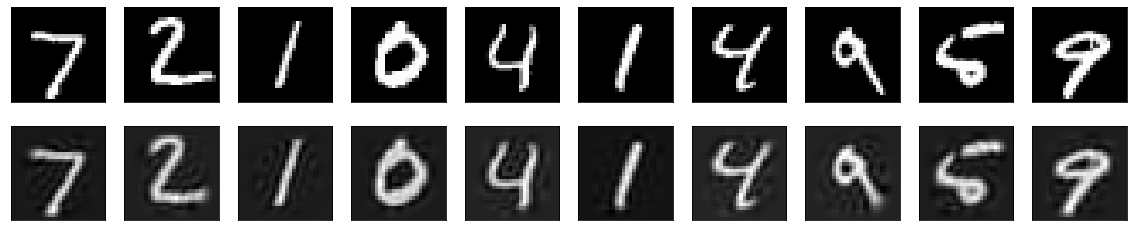

In [9]:
plot_img(10, x_test, x_test_reco)

# **Discussions**
I have tried different values of encoding dimension, which are 50 250 and 650. I have realized that for bigger values, the quality of images which are reconstructed are better, also the mean square error decreases to 0.00 when the encoding dimension becomes 650. Which actually means that there is almost no difference between the original and reconstructud images. You can see the results of three different encoding dimension values below:



# **Encoding Dimension 50**
training mse: 0.01183 test mse: 0.01150


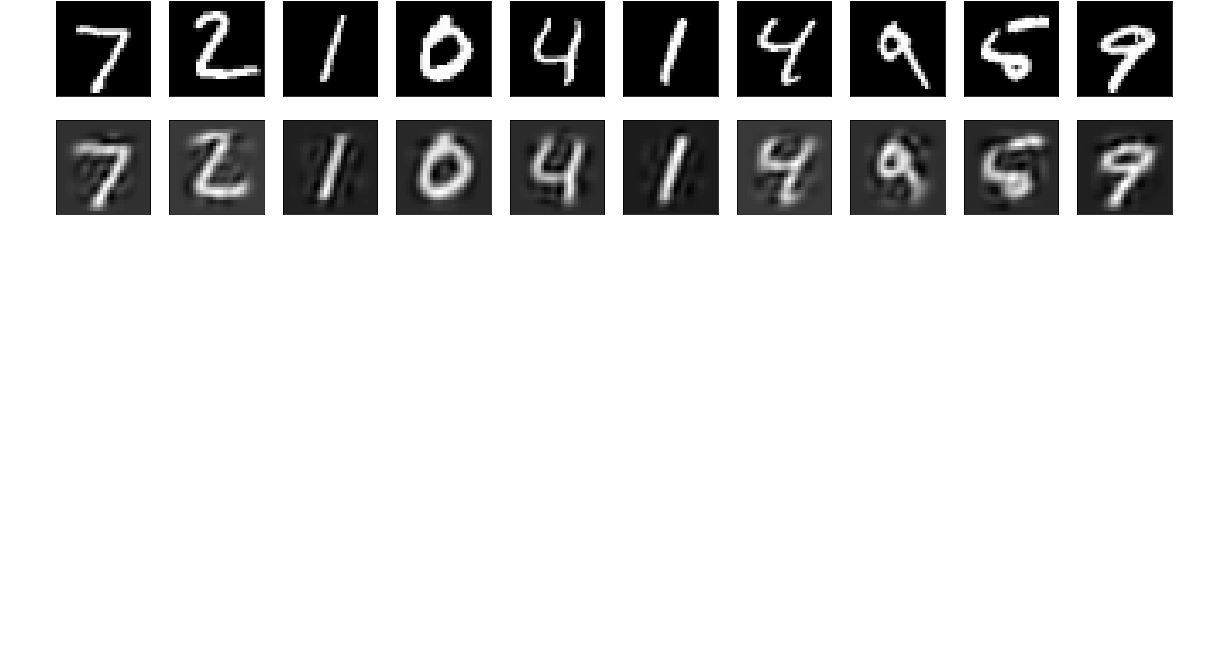

# **Encoding dim 250**
training mse: 0.00147
test mse: 0.00146

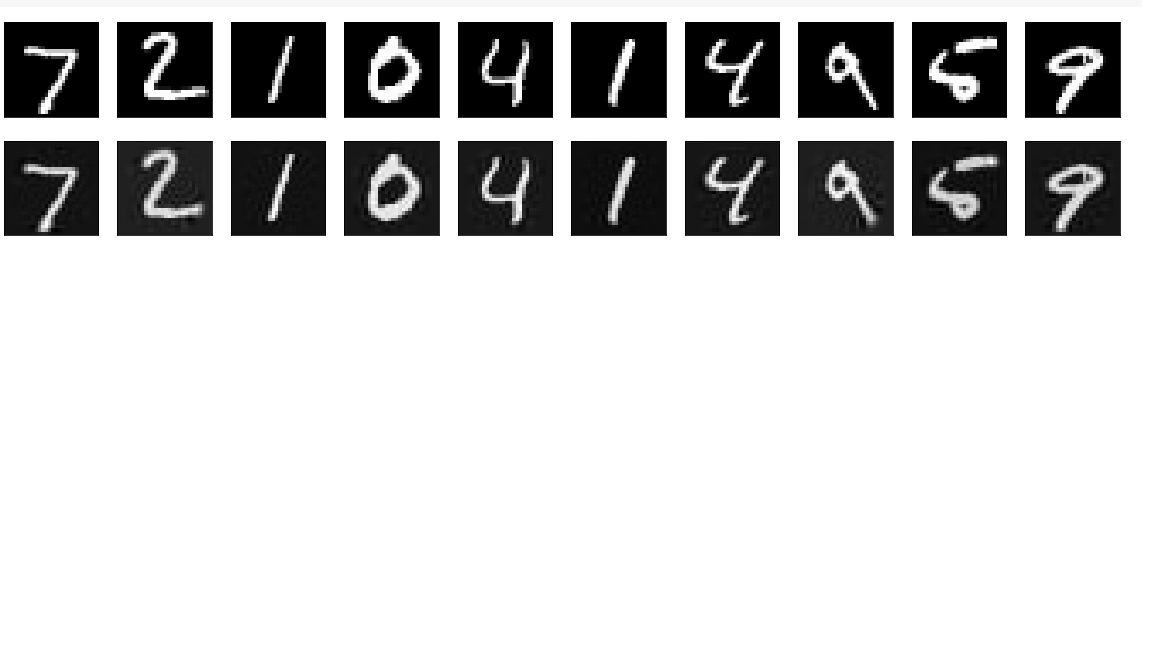

# **Encoding Dim 650**
training mse: 0.00000
test mse: 0.00000

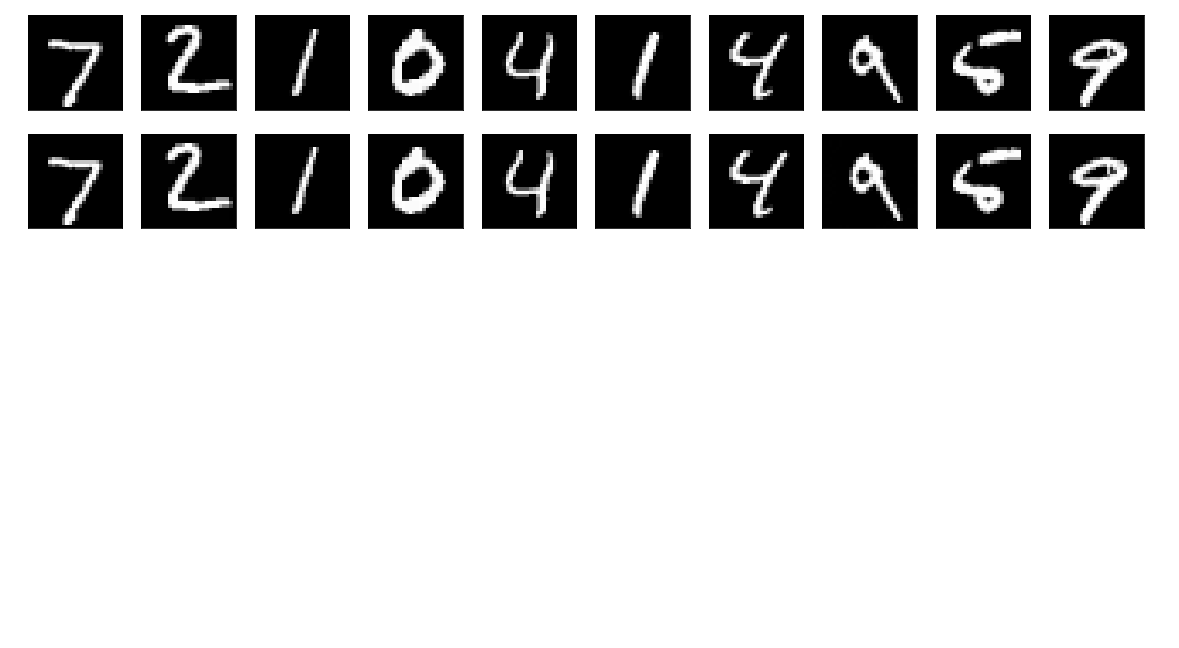

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

**[TO COMPLETE]** check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [10]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [12]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 4s 5ms/step - loss: 0.0425 - val_loss: 0.0145
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0088
Epoch 3/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 5/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 6/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 7/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 9/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 11/15
98/98 [

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [13]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0050
test mse: 0.00501


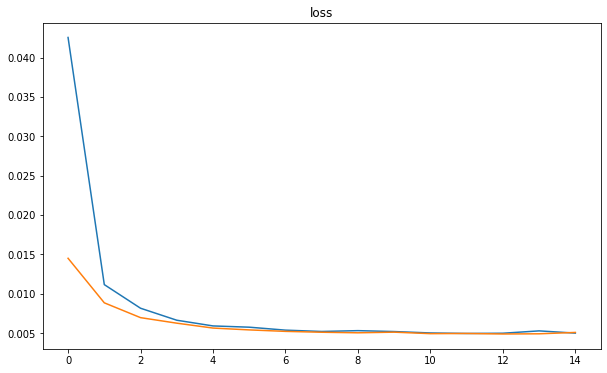

In [14]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

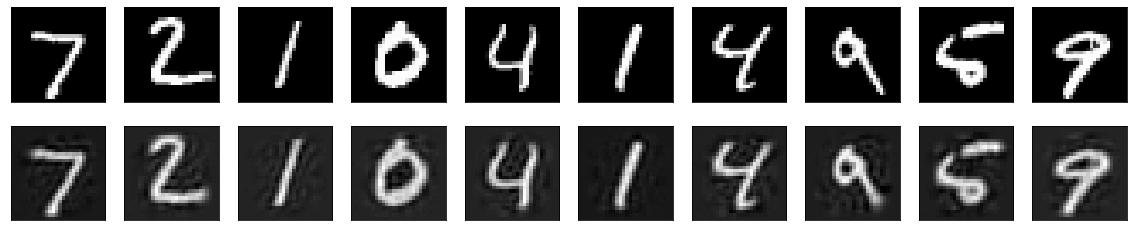

In [15]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


# **Discussions:**
I am going to compare the results on both PCA(SVD) and Shallow Linear Autoencoder with Encoding Dimension=120 and 650 

1. Dim=120 

PCA(SVD) test mean squared error: 0.00455


Shallow Linear Autoencoder test mean squared error: 0.00476

I can say that it is almost the same test mean squared error for dimension 120. The reason why is because theoretically both methods are equivalent.

2. Dim=650 

PCA(SVD) test mean squared error: 0

Shallow Linear Autoencoder test mean squared error: 0.00127

therefore we can see that for a larger number of dimensions, PCA(SVD) is able to make the error 0 but it is not the same for Shallow Linear Autoencoder.

I think the reason why is PCA is able to fully represent the data with no erors, but on the other hand, The autoencoder learns the features using the encoder part this is why the representation wont be perfect and I think this makes the difference why it is not able to find zero even after 650 dimensions


##[TO COMPLETE] Exercise 5.3: Shallow non-linear autoencoders

**[TO COMPLETE]** replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. (Insert your code and  theoretical discussion into  cells immediately below this one.)


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0548 - val_loss: 0.0346
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0274 - val_loss: 0.0213
Epoch 3/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0181 - val_loss: 0.0151
Epoch 4/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss

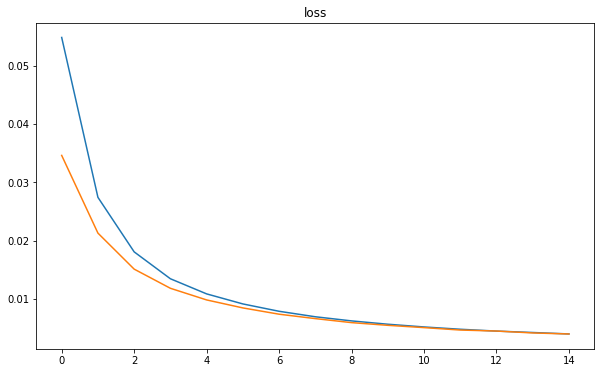

In [18]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded_nonlinear = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded_nonlinear = tf.keras.layers.Dense(784, activation='sigmoid')(encoded_nonlinear)

#and finally the autoencoder
autoencoder_nonlinear = tf.keras.models.Model(input_img, decoded_nonlinear)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder_nonlinear = tf.keras.models.Model(input_img, encoded_nonlinear)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder_nonlinear.layers[-1]
decoded_nonlinear = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder_nonlinear.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
autoencoder_nonlinear.summary()

history_nonlinear = autoencoder_nonlinear.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
plot_loss(history_nonlinear)

score_nonlinear = autoencoder_nonlinear.evaluate(x_test,x_test,verbose=2);
print("test mse: %.5f" % (score_nonlinear))



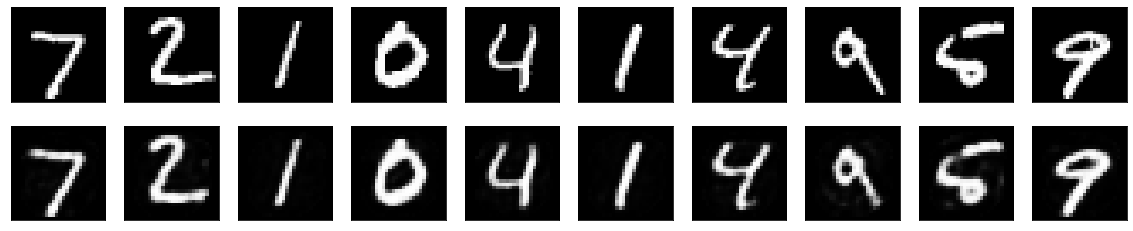

In [19]:
encoded_image = encoder_nonlinear.predict(x_test)
decoded_image = decoded_nonlinear.predict(encoded_image)

plot_img(10, x_test, decoded_image)


# **Discussions**
First of all the activation function I have chosen is sigmoid. Using sigmoid gave better results compared to tanh and RELU. Sigmoid has a range between 0 and 1, which is appropriate to use with our data because our input representation is also between 0 and 1. 

Shallow Non Linear test mse: 0.00388

Shallow Linear test mse: 0.00501

The difference between both models is 0.001 which is a really small value.
Eventhough the mean squared errors are so close, the resulting images obtained from shallow non linear autoencoder is less blurred and has more quality especially on the background.

The reason why the Shallow Non Linear Autoencoder is better,when comparing the resulting images is because it has a non linear activation function, therefore it can model a more complex space compared to linear one.

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [58]:
input_img = tf.keras.layers.Input(shape=(784,))
#Encoding part
encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)


#Decoding Part
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_31 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [90]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 512, shuffle=True, validation_data=(x_valid, x_valid))



Epoch 1/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0161 - val_loss: 0.0106
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 3/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 4/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 5/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 6/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 8/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 11/15
98/98 [

313/313 - 0s - loss: 0.0031
test mse: 0.00310


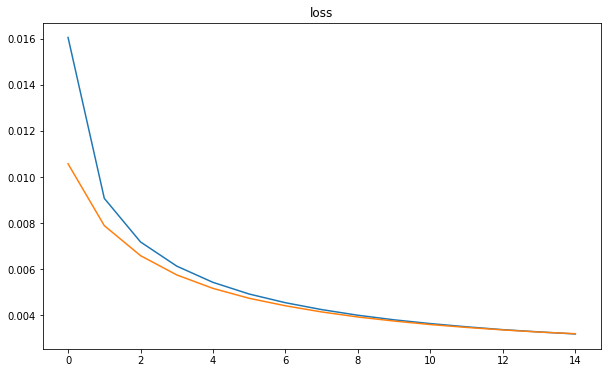

In [91]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

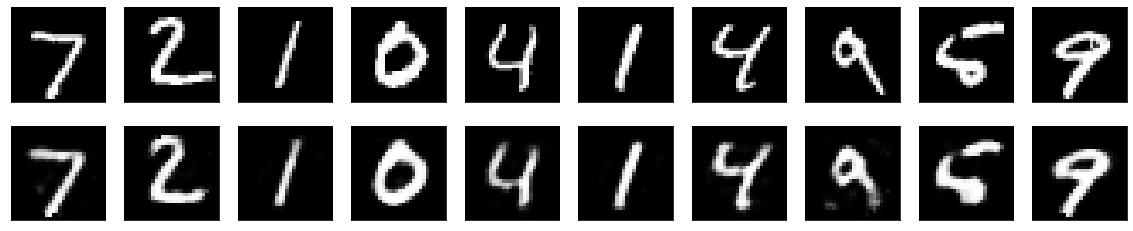

In [61]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


# **Discussion**

Deep autoencoder has the structure for encoder 784->128->64 and 128->784 for decoder, which is the best model obtained. I have tried
784->256->128->64 for encoder and 128->256->784 for decoder but the results was really bad. The activation functions are relu and sigmoid, I have tried tanh function instead of sigmoid but I have obtained more blurred images. So this of the activation functions is way better.
I have tried different batch sizes to get a performance improvement, and I have decided on a batch size of 512 and epochs 15.

 

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.
**NOTE: in the code at the bottom noise_factor is added and not multiplied for numerical reasons. You may want to try the version with multiplication to verify it is more unstable.**


In [62]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

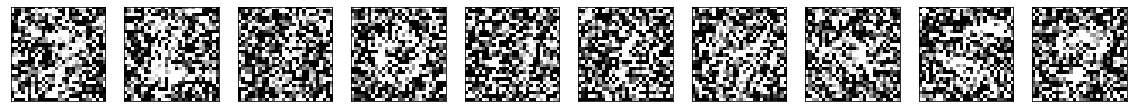

In [63]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [66]:
#[TO COMPLETE]

input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')



In [67]:
autoencoder.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_36 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_37 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [92]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15 ,batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid))#[TO COMPLETE]

Epoch 1/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0435 - val_loss: 0.0393
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0369 - val_loss: 0.0371
Epoch 3/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0352 - val_loss: 0.0362
Epoch 4/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0344 - val_loss: 0.0355
Epoch 5/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0337 - val_loss: 0.0350
Epoch 6/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0330 - val_loss: 0.0345
Epoch 7/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0326 - val_loss: 0.0343
Epoch 8/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0341
Epoch 9/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0322 - val_loss: 0.0341
Epoch 10/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0321 - val_loss: 0.0339
Epoch 11/15
98/98 [

313/313 - 0s - loss: 0.0334
test mse: 0.03344


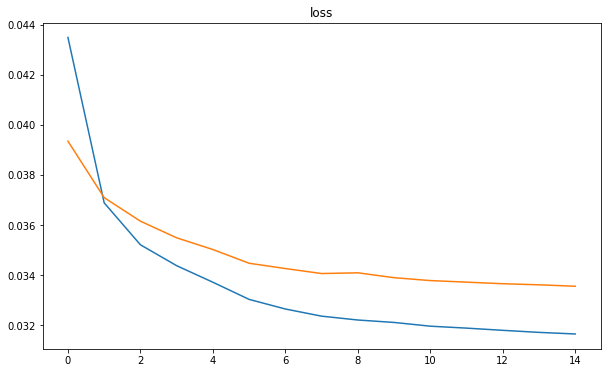

In [93]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

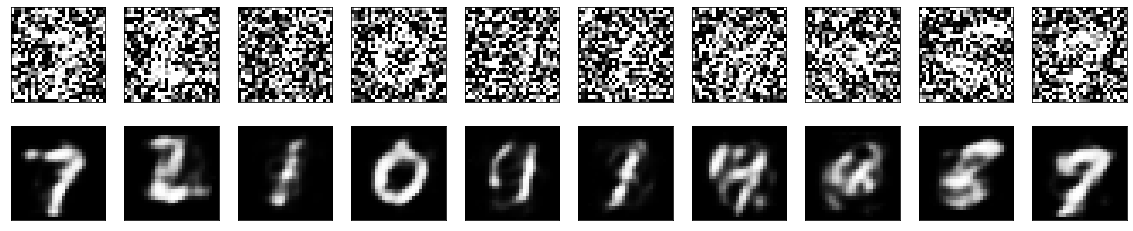

In [94]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [73]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [78]:
#from keras.utils import to_categorical (this wasnt working for my code)
from tensorflow.keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [79]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 5s 60ms/step - loss: 0.1532 - categorical_accuracy: 0.2275 - val_loss: 0.0807 - val_categorical_accuracy: 0.4341
Epoch 2/50
79/79 [==============================] - 4s 57ms/step - loss: 0.0690 - categorical_accuracy: 0.4760 - val_loss: 0.0640 - val_categorical_accuracy: 0.4919
Epoch 3/50
79/79 [==============================] - 5s 58ms/step - loss: 0.0600 - categorical_accuracy: 0.5250 - val_loss: 0.0590 - val_categorical_accuracy: 0.5389
Epoch 4/50
79/79 [==============================] - 4s 57ms/step - loss: 0.0542 - categorical_accuracy: 0.5512 - val_loss: 0.0523 - val_categorical_accuracy: 0.5540
Epoch 5/50
79/79 [==============================] - 4s 57ms/step - loss: 0.0488 - categorical_accuracy: 0.5820 - val_loss: 0.0474 - val_categorical_accuracy: 0.5891
Epoch 6/50
79/79 [==============================] - 5s 57ms/step - loss: 0.0444 - categorical_accuracy: 0.6124 - val_loss: 0.0430 - val_categorical_accuracy: 0.6373
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0152 - categorical_accuracy: 0.9077
categorical_accuracy: 90.77%


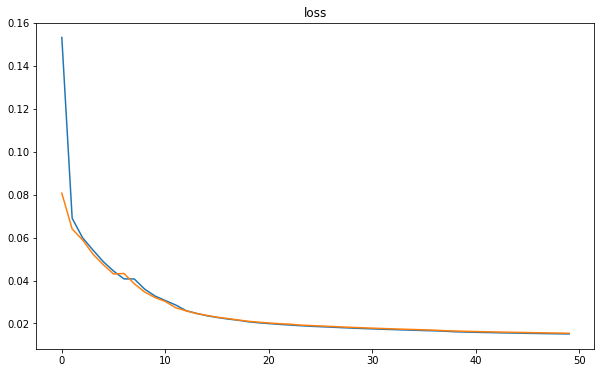

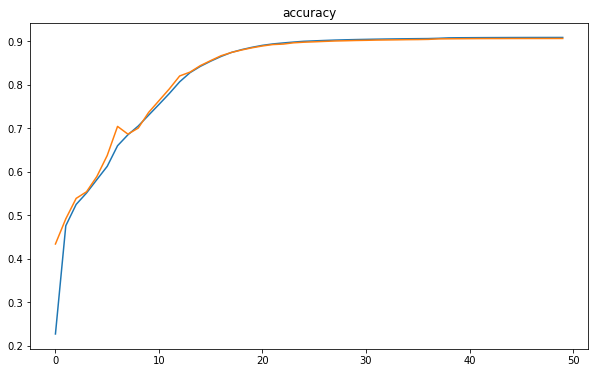

In [81]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [82]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
<oov> a <oov> <oov> be are <oov> in all of first time but like <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> of some other <oov> have <oov> a it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film bad <oov> <oov> <oov> on its <oov> of <oov> <oov> i <oov> it <oov> <oov> of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [89]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, activation='sigmoid', return_sequences=True)(inputs)
decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 12s 134ms/step - loss: 0.0449 - categorical_accuracy: 0.3346 - val_loss: 0.0373 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 10s 133ms/step - loss: 0.0364 - categorical_accuracy: 0.4710 - val_loss: 0.0365 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] 

40/40 - 0s - loss: 2.4884e-05 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


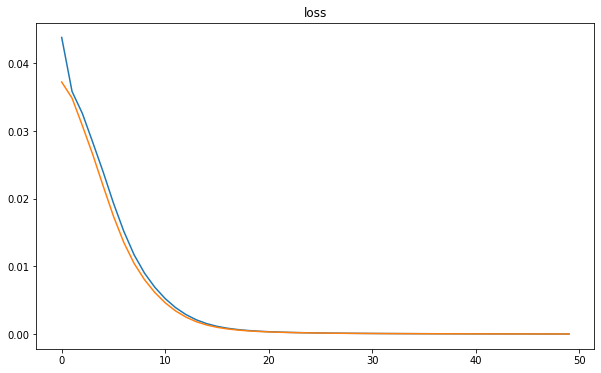

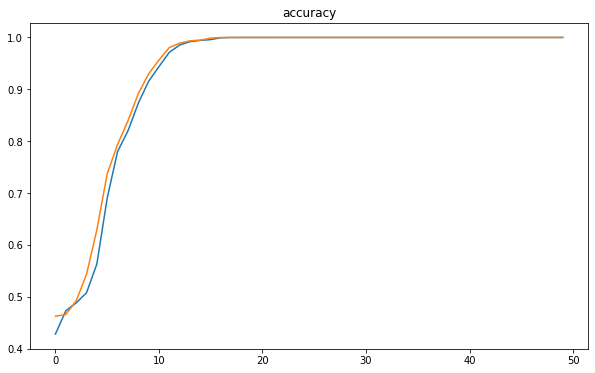

In [88]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

# **Discussions**

It is a multiclass classification problem, therefore I have used softmax in the last layer. And the first activation function I have chosen sigmoid, because with relu the result was really bad, so I have picked sigmoid activation function.

Performance Comparison:
1. Linear Autoencoder for sequence: loss: 0.0152 - categorical_accuracy: 0.9077

2. Non linear Autoencoder for sequences: loss: 2.4884e-05 - categorical_accuracy: 1.0000


The linear Autoencoder for sequences has an accuracy 90.77% which is not so bad, but non linear autoencoder performs much more better than the linear one with an accuracy value of 100%. But non linear autoencoder is much complex if we check the number of total parameters,
for non linear it is  35,300
and for linear it is 12,650.

The non linear autoencoder has the advantage of using the non linear activation functions and LSTM layer therefore I think this performance comes from those.



